# 毫米波电线检测

---

# 目录

- [数据](#数据)
- [IOU](#IOU)
- [$k$-折交叉验证](#$k$-%E6%8A%98%E4%BA%A4%E5%8F%89%E9%AA%8C%E8%AF%81)
- [训练](#训练)
- [训练过程曲线](#训练过程曲线)
- [测试](#测试)

## 数据

1. 进入代码目录

In [1]:
cd /home/alvin/opt/git/powerline/model_fusion

/opt/git/powerline/model_fusion


In [22]:
import matplotlib.pyplot as plt

from torchvision import transforms
from dataset.utils import *
from dataset.powerline_Dataset import get_all_images_list, powerline_Dataset,split_train_val_dataset_list

%matplotlib inline

In [161]:
%matplotlib inline
import os
import  scipy.io as sio
import matplotlib.pyplot as plt


data_root = "data/figure/"


samples = [os.path.join(data_root, item, "Data_Ori_Param.mat") for item in next(os.walk(data_root))[1]]

sample_path = samples[0]


data = sio.loadmat(sample_path)["Data_Ori_Param"]


sample = []
for i in range(data.shape[1]):
    print(data[0,i].dtype.names)


('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'SumDatadB', 'Mask_img', 'XY', 'AZ_range', 'R_range')
('El', 'AZ', 'LLHY', 'Sum

In [48]:
train_list, val_list = split_train_val_dataset_list("data", ratio=0.3)

In [19]:
train_dataset= powerline_Dataset(train_list, transform=transforms.Compose([
        ReSize((512, 512)),
        BgrToRgb(),
        AnnotationBinarization(),
        # ToTensor(), 
        # Normalize_to_one(),
        # Normalize(mean=[0.485, 0.456, 0.406], 
        #     std=[0.229, 0.224, 0.225]),
        ]))

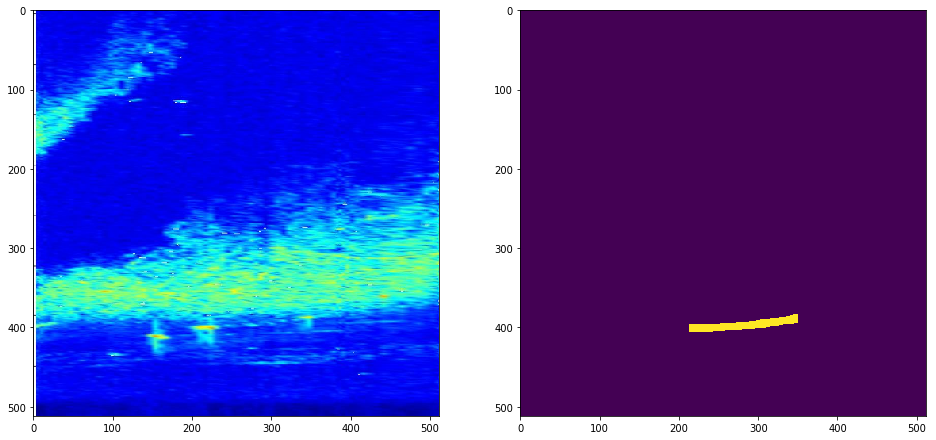

In [47]:
# train data display
idx = 45

sample=train_dataset[idx]

im,label = sample


figsize=[16,8]
fig = plt.figure(figsize=figsize)

axes = fig.subplots(1,2)

axes[0].imshow(im)
axes[1].imshow(label)

fig.show()


## IOU

In [99]:
import torch
import math

def IoU(predicts, labels):
    assert(predicts.shape == labels.shape)
    batch = labels.size()[0]
    predicts = torch.sigmoid(predicts)>=0.5
        
    A = predicts.view(batch, -1)
    B = labels.view(batch, -1)
    
    inner = (A&B).sum(dim=1)
    union = (A|B).sum(dim=1)
    
    ious = inner.float()/union.float()  
    
    ious = ious[~torch.isinf(ious) & ~torch.isnan(ious)]
    
    return (ious.sum()/len(ious)).item()
    
model = fixed_UNetResNet34_v2()

inputs = torch.randn((1,3,512,512), dtype=torch.float)
labels = torch.ones((1,1,512,512), dtype=torch.uint8)


predicts = model(inputs)

print(IoU(predicts, labels))



0.4704551696777344


# $k$-折交叉验证

**交叉验证：**先将数据集$D$划分为$k$个大小相似的互斥子集，即$D=D_1\cup D_2\cdots D_k, D_i\cap D_j=\phi(i\neq j).$每一个子集都尽量保持数据分布的一致性，即从$D$中通过分层采样得到。然后每次用$k-1$个自己的并集作为训练集，余下的那个子集作为测试集；这样就可以获得$k$组**_训练/测试集_**，从而可进行$k$次训练和测试，最终返回的是这$k$个测试结果的均值。

示意图：
![$k$-折交叉验证](https://gss3.bdstatic.com/7Po3dSag_xI4khGkpoWK1HF6hhy/baike/c0%3Dbaike80%2C5%2C5%2C80%2C26/sign=23cdb2af33292df583cea447dd583705/8326cffc1e178a820e220820ff03738da977e810.jpg)

In [5]:
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]

kf = KFold(n_splits=4)

for train, test in kf.split(X):
    print("%s %s" % (train, test))
    
    
for i in range(5):
    pass

print(i)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]
4


## 训练

In [ ]:
%run train_k_folds.py

 fold | epoch | train time | learn rate | train loss | train  acc |   val loss |  val  acc 
------+-------+------------+------------+------------+------------+------------+-----------
    0 |    0  |    9.00s   | 0.00100000 | 0.10664745 | 0.00218993 | 0.03479251 | 0.00000000
    0 |    1  |    8.91s   | 0.00100000 | 0.04013582 | 0.00000000 | 0.03221526 | 0.00000000
    0 |    2  |    8.91s   | 0.00100000 | 0.02935319 | 0.14392152 | 0.04070747 | 0.03980692
    0 |    3  |    9.22s   | 0.00100000 | 0.02631396 | 0.24957518 | 0.02870591 | 0.31659028
    0 |    4  |    9.30s   | 0.00100000 | 0.02963074 | 0.22777595 | 0.01847922 | 0.29709363
    0 |    5  |    9.02s   | 0.00100000 | 0.02099798 | 0.36981222 | 0.01888579 | 0.29804111
    0 |    6  |    8.82s   | 0.00100000 | 0.02002092 | 0.38372073 | 0.03068108 | 0.10503169
    0 |    7  |    8.84s   | 0.00100000 | 0.01992600 | 0.40836594 | 0.02054148 | 0.29443148
    0 |    8  |    8.86s   | 0.00100000 | 0.01906291 | 0.42595625 | 0.02086812 |

    1 |   74  |    8.93s   | 0.00000001 | 0.00399169 | 0.85693687 | 0.04841870 | 0.34160244
    1 |   75  |    8.93s   | 0.00000001 | 0.00399164 | 0.85693824 | 0.04508528 | 0.36497033
    1 |   76  |    8.94s   | 0.00000001 | 0.00399160 | 0.85694200 | 0.04733477 | 0.35165045
    1 |   77  |    8.94s   | 0.00000001 | 0.00399156 | 0.85694361 | 0.05091349 | 0.29927388
    1 |   78  |    8.93s   | 0.00000001 | 0.00399151 | 0.85694182 | 0.04672534 | 0.35581931
    1 |   79  |    8.92s   | 0.00000001 | 0.00399147 | 0.85693204 | 0.04656694 | 0.34069476
    1 |   80  |    8.96s   | 0.00000001 | 0.00399142 | 0.85694617 | 0.04913060 | 0.32054457
    1 |   81  |    8.96s   | 0.00000001 | 0.00399139 | 0.85694695 | 0.05422501 | 0.26760739
    1 |   82  |    8.95s   | 0.00000001 | 0.00399134 | 0.85694116 | 0.04859147 | 0.32445696
    1 |   83  |    9.30s   | 0.00000001 | 0.00399129 | 0.85694319 | 0.06057674 | 0.21541095
    1 |   84  |    9.20s   | 0.00000001 | 0.00399126 | 0.85694677 | 0.05741167 |

    3 |   48  |    8.99s   | 0.00001000 | 0.00413125 | 0.84661436 | 0.05510410 | 0.28377998
    3 |   49  |    8.98s   | 0.00000100 | 0.00407290 | 0.84900802 | 0.05312851 | 0.29784697
    3 |   50  |    8.98s   | 0.00000100 | 0.00406930 | 0.84912616 | 0.04950817 | 0.32123661
    3 |   51  |    8.95s   | 0.00000100 | 0.00406572 | 0.84923750 | 0.04946131 | 0.34762990
    3 |   52  |    8.95s   | 0.00000100 | 0.00406194 | 0.84923381 | 0.05307829 | 0.31566906
    3 |   53  |    8.96s   | 0.00000100 | 0.00405958 | 0.84933507 | 0.05718537 | 0.27841210
    3 |   54  |    8.98s   | 0.00000100 | 0.00405685 | 0.84943193 | 0.05353948 | 0.29813376
    3 |   55  |    8.98s   | 0.00000100 | 0.00405345 | 0.84972072 | 0.05447586 | 0.29754657
    3 |   56  |    8.96s   | 0.00000100 | 0.00404988 | 0.84992117 | 0.05422165 | 0.29412809
    3 |   57  |    8.96s   | 0.00000100 | 0.00404710 | 0.85010993 | 0.04582467 | 0.36727008
    3 |   58  |    8.95s   | 0.00000100 | 0.00404304 | 0.85014504 | 0.05452487 |

## 训练过程曲线

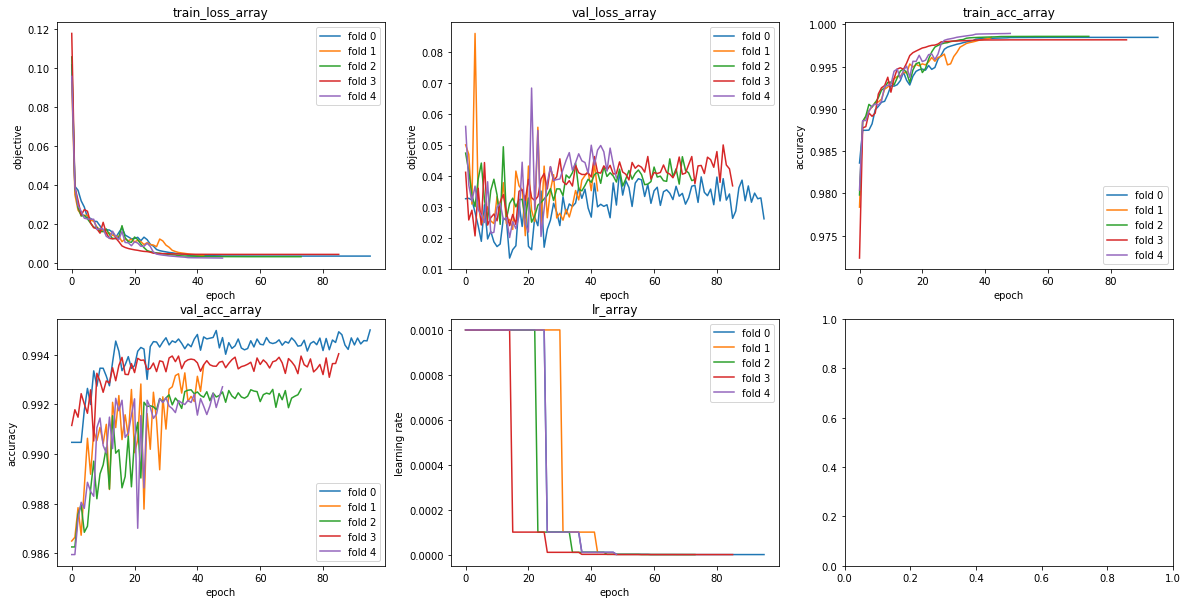

In [3]:
%matplotlib inline

import os
import os.path
import numpy as np
import matplotlib.pyplot as plt


from utils.checkpoint import Checkpoint


def k_fold_cross_validate_checkpoint_visualization(k, model_name, checkpoint_root, figsize=[20, 10]):
    model_save_root = os.path.join(checkpoint_root, model_name)

    ## 加载交叉验证模型
    checkpoint = {}
    for fold in range(k):
        chekcpoint_path = os.path.join(model_save_root, str(fold), model_name+".pth")
        checkpoint[fold] = Checkpoint().load(chekcpoint_path)

    ## 训练过程可视化

    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(2, 3)


    for fold in range(k):
        axes[0,0].plot(np.array(checkpoint[fold].train_loss_array), label="fold "+str(fold))
        axes[0,1].plot(np.array(checkpoint[fold].val_loss_array), label="fold "+str(fold))
        axes[0,2].plot(np.array(checkpoint[fold].train_acc_array), label="fold "+str(fold))
        axes[1,0].plot(np.array(checkpoint[fold].val_acc_array), label="fold "+str(fold))
        axes[1,1].plot(np.array(checkpoint[fold].lr_array), label="fold "+str(fold))

    axes[0,0].set(xlabel="epoch", ylabel="objective", title="train_loss_array")
    axes[0,1].set(xlabel="epoch", ylabel="objective", title="val_loss_array")
    axes[0,2].set(xlabel="epoch", ylabel="accuracy", title="train_acc_array")
    axes[1,0].set(xlabel="epoch", ylabel="accuracy", title="val_acc_array")
    axes[1,1].set(xlabel="epoch", ylabel="learning rate", title="lr_array")

    axes[0,0].legend()
    axes[0,1].legend()
    axes[0,2].legend()
    axes[1,0].legend()
    axes[1,1].legend()
    

## 交叉验证k
k=5

checkpoint_root=".chekcpoints"

## 模型名称
model_name="resunet"
k_fold_cross_validate_checkpoint_visualization(k, model_name, checkpoint_root)

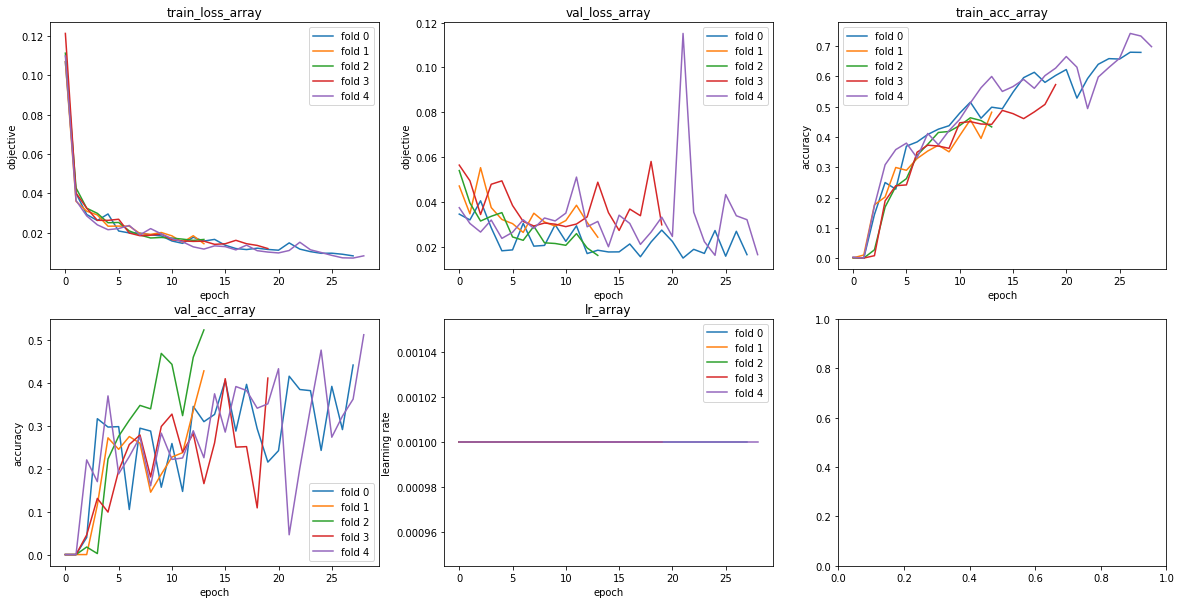

In [4]:
## 交叉验证k
k=5

## 模型名称
model_name="resunet_iou"
k_fold_cross_validate_checkpoint_visualization(k, model_name, checkpoint_root)

## 测试

In [5]:
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from torch.utils.data import DataLoader
from torchvision import transforms
from model import fixed_UNetResNet34_v2
from utils.checkpoint import Checkpoint
from dataset.powerline_Dataset import get_all_images_list, powerline_Dataset
from dataset.utils import *

## 交叉验证k
k=5

checkpoint_root=".chekcpoints"
test_root = "outputs"

## 模型名称
model_name="resunet_iou"

model_save_root = os.path.join(checkpoint_root, model_name)

test_output_root = os.path.join(test_root, model_name)

## 加载交叉验证模型
checkpoint = {}
for fold in range(k):
    chekcpoint_path = os.path.join(model_save_root, str(fold), model_name+".pth")
    checkpoint[fold] = Checkpoint().load(chekcpoint_path)
    
    
transform=transforms.Compose(
    [
        ReSize((512, 512)),
        BgrToRgb(),
        AnnotationBinarization(),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ]
)
   
    
def IoU(predicts, labels):
    assert(predicts.shape == labels.shape)
    batch = labels.size()[0]
    predicts = torch.sigmoid(predicts)>=0.5
    A,B = predicts.view(batch, -1), labels.view(batch, -1)
    inner = (A&B).sum(dim=1)
    union = (A|B).sum(dim=1)
    ious = inner.float()/union.float()
    
    ious = ious[~torch.isinf(ious) & ~torch.isnan(ious)]
    
    return (ious.sum()/ious.shape[0])

    
data = get_all_images_list("data")
dataset = powerline_Dataset(data, transform=transform)


## loss
criterion = nn.BCEWithLogitsLoss()
accuracy = IoU


for fold in range(k):
    model = fixed_UNetResNet34_v2()
    model.load_state_dict(checkpoint[fold].model_state)
    model = model.cuda()
    
    ckpt = Checkpoint()
    
    fold_test_root = os.path.join(test_output_root, str(fold))
    fold_test_state_path = os.path.join(fold_test_root, str(fold)+".pth")
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    model.eval()
    
    loss_array = []
    acc_array = []
    test_outputs_array = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            acc = accuracy(outputs, labels)

            loss_array.append(loss.item())
            acc_array.append(acc.item())
            test_outputs_array.append({
                "images":inputs.cpu().detach().squeeze().numpy(),
                "labels":labels.cpu().detach().squeeze().numpy(),
                "predicts":outputs.cpu().detach().squeeze().numpy(),
            })
            
    ckpt.save(fold_test_state_path, **{
        "loss_array":loss_array,
        "acc_array":acc_array,
        "test_outputs_array":test_outputs_array
    })

In [6]:
%matplotlib inline
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm 

from utils.checkpoint import Checkpoint


def IoU_(predicts, labels):
    assert(predicts.shape == labels.shape)
    batch = labels.size()[0]
    predicts = predicts>=0.5
    A,B = predicts.view(batch, -1), labels.view(batch, -1)
    inner = (A&B).sum(dim=1)
    union = (A|B).sum(dim=1)
    ious = inner.float()/union.float()
    
    ious = ious[~torch.isinf(ious) & ~torch.isnan(ious)]
    
    return (ious.sum()/ious.shape[0])


## 交叉验证k
k=5

test_root = "outputs"

## 模型名称
model_name="resunet_iou"

test_output_root = os.path.join(test_root, model_name)


print("加载模型")
test_checkpoint = {}
for fold in tqdm.tqdm(range(k)):
    chekcpoint_path = os.path.join(test_output_root, str(fold), str(fold)+".pth")
    test_checkpoint[fold] = Checkpoint().load(chekcpoint_path)
    
    
fusion_test_root = os.path.join(test_output_root, "fusion")
fusion_state_path = os.path.join(fusion_test_root, "fusion"+".pth")

criterion = nn.BCELoss()
accuracy = IoU_

ckpt = Checkpoint()
loss_array = []
acc_array = []
test_outputs_array=[]

print("模型融合")

for i in tqdm.tqdm(range(len(test_checkpoint[0].acc_array))):
    outputs = torch.sigmoid(torch.from_numpy(test_checkpoint[0].test_outputs_array[i]["predicts"]).cuda())
    for fold in range(1,k):
        outputs += torch.sigmoid(torch.from_numpy(test_checkpoint[fold].test_outputs_array[i]["predicts"]).cuda())
        
    outputs /= k
    
    images = test_checkpoint[0].test_outputs_array[i]["images"]
    labels = torch.from_numpy(test_checkpoint[0].test_outputs_array[i]["labels"]).cuda()
    
    loss = criterion(outputs, labels.float())
    acc = accuracy(outputs, labels)
    
    loss_array.append(loss.item())
    acc_array.append(acc.item())
    test_outputs_array.append({
        "images":images,
        "labels":labels.cpu().detach().squeeze().numpy(),
        "predicts":outputs.cpu().detach().squeeze().numpy(),
    })
    
# ckpt.save(fusion_state_path, **{
#     "loss_array":loss_array,
#     "acc_array":acc_array,
#     "test_outputs_array":test_outputs_array
# })



  0%|          | 0/5 [00:00<?, ?it/s]

加载模型


  5%|▌         | 31/564 [00:00<00:01, 302.61it/s]

模型融合


100%|██████████| 564/564 [00:01<00:00, 412.45it/s]


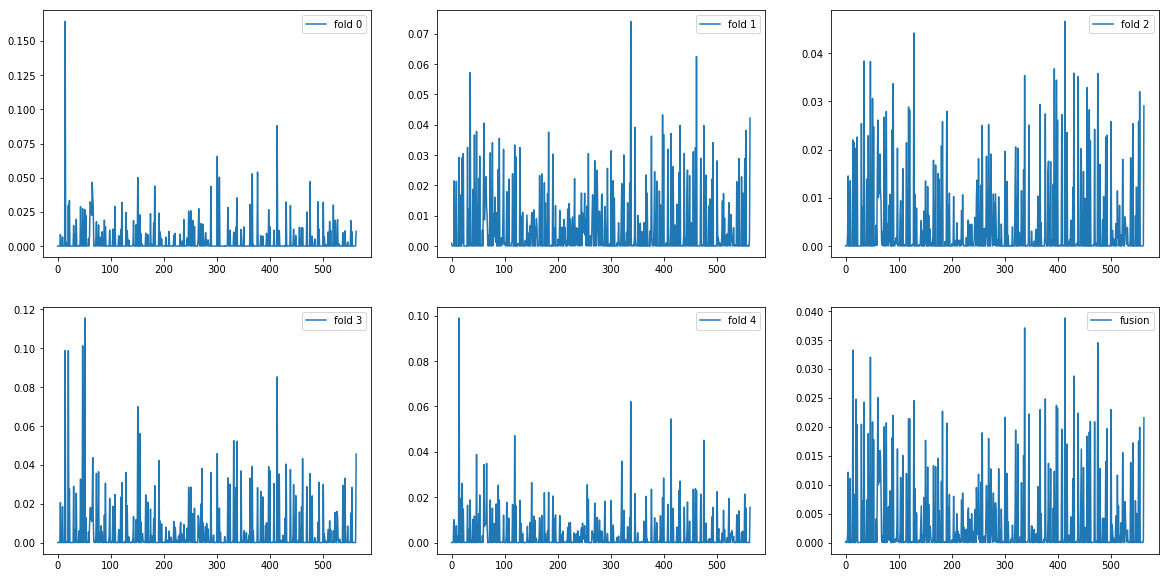

In [7]:
figsize=[20,10]
fig = plt.figure(figsize=figsize)
axes = fig.subplots(2, 3)
axes[0,0].plot(np.array(test_checkpoint[0].loss_array), label="fold 0")
axes[0,1].plot(np.array(test_checkpoint[1].loss_array), label="fold 1")
axes[0,2].plot(np.array(test_checkpoint[2].loss_array), label="fold 2")
axes[1,0].plot(np.array(test_checkpoint[3].loss_array), label="fold 3")
axes[1,1].plot(np.array(test_checkpoint[4].loss_array), label="fold 4")
axes[1,2].plot(np.array(loss_array), label="fusion")

axes[0,0].legend()
axes[0,1].legend()
axes[0,2].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[1,2].legend()

fold |     0    |    1     |     2    |    3     |    4     | fusion
-----+----------+----------+----------+----------+----------+--------
     | 0.429004 | 0.238332 | 0.290792 | 0.261750 | 0.404646 | 0.365125


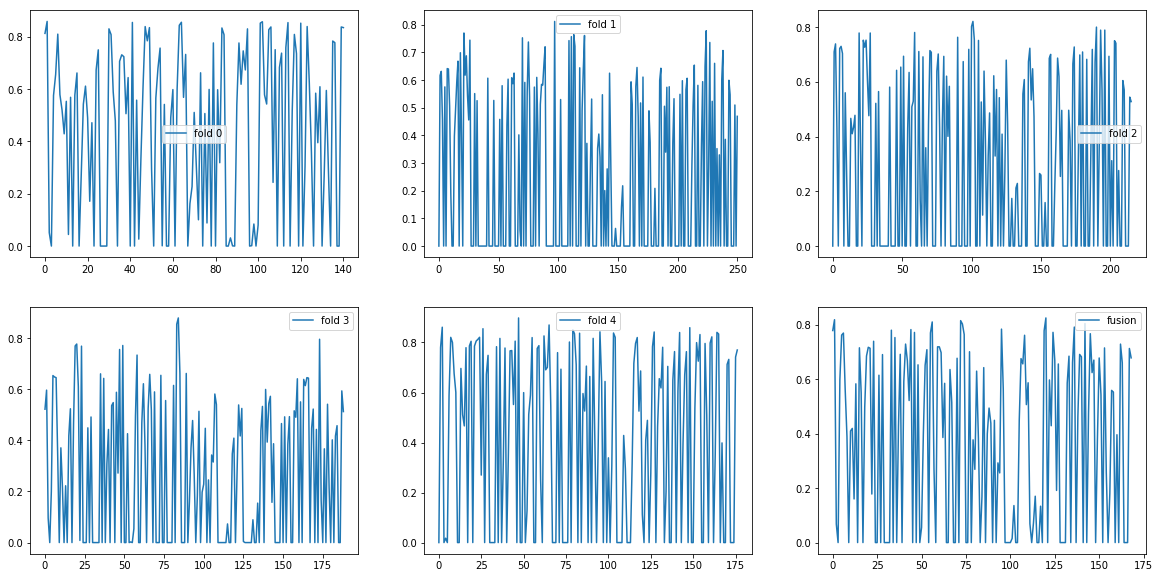

In [8]:
acc0 = np.array(test_checkpoint[0].acc_array)
acc1 = np.array(test_checkpoint[1].acc_array)
acc2 = np.array(test_checkpoint[2].acc_array)
acc3 = np.array(test_checkpoint[3].acc_array)
acc4 = np.array(test_checkpoint[4].acc_array)
acc = np.array(acc_array)

acc0 = acc0[acc0==acc0]
acc1 = acc1[acc1==acc1]
acc2 = acc2[acc2==acc2]
acc3 = acc3[acc3==acc3]
acc4 = acc4[acc4==acc4]
acc = acc[acc==acc]


acc0_mean = acc0.mean()
acc1_mean = acc1.mean()
acc2_mean = acc2.mean()
acc3_mean = acc3.mean()
acc4_mean = acc4.mean()
acc_mean = acc.mean()
                

print("fold |     0    |    1     |     2    |    3     |    4     | fusion") 
print("-----+----------+----------+----------+----------+----------+--------")
print("     | {:4f} | {:4f} | {:4f} | {:4f} | {:4f} | {:4f}".format(
    acc0_mean, acc1_mean, acc2_mean, acc3_mean, acc4_mean, acc_mean))


figsize=[20,10]
fig = plt.figure(figsize=figsize)
axes = fig.subplots(2, 3)
axes[0,0].plot(acc0, label="fold 0")
axes[0,1].plot(acc1, label="fold 1")
axes[0,2].plot(acc2, label="fold 2")
axes[1,0].plot(acc3, label="fold 3")
axes[1,1].plot(acc4, label="fold 4")
axes[1,2].plot(acc, label="fusion")

axes[0,0].legend()
axes[0,1].legend()
axes[0,2].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[1,2].legend()